# SDSS Datathon 2025 - Predicting Real Estate Prices Based on Geospatial Quality of Living Factors

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
# uploaded = files.upload()

Import provided real estate data set and external data set

In [2]:
real_estate = pd.read_csv('real-estate-data.csv')
police = pd.read_csv('toronto-police.csv')

# Data cleaning and normalization

In [3]:
real_estate.isna().sum()

,0
id_,0
ward,0
beds,54
baths,0
DEN,0
size,53
parking,0
exposure,0
D_mkt,93
building_age,0


In [4]:
real_estate = real_estate.dropna(subset=['price'])

In [5]:
real_estate.isna().sum()

,0
id_,0
ward,0
beds,52
baths,0
DEN,0
size,53
parking,0
exposure,0
D_mkt,90
building_age,0


In [6]:
police = police.rename(columns={'X': 'lt', 'Y': 'lg'})

In [7]:
police.isna().sum()

,0
lt,0
lg,0
Index_,0
event_unique_id,0
occurrencedate,0
reporteddate,0
premisetype,0
ucr_code,0
ucr_ext,0
offence,0


In [8]:
real_estate['lt'] = pd.to_numeric(real_estate['lt'], errors='coerce')
real_estate['lg'] = pd.to_numeric(real_estate['lg'], errors='coerce')
police['lt'] = pd.to_numeric(police['lt'], errors='coerce')
police['lg'] = pd.to_numeric(police['lg'], errors='coerce')

real_estate = real_estate.dropna(subset=['lt', 'lg'])
police = police.dropna(subset=['lt', 'lg'])

# Feature engineering

Turn 'DEN' into binary value

In [9]:
real_estate['DEN'] = real_estate['DEN'].map({'Yes': 1, 'No': 0})
real_estate['parking'] = real_estate['parking'].map({'Yes': 1, 'No': 0})

Utilize SKLearn Balltree library to calculate haversine distance around each real estate

In [10]:
# Convert degree coordinates to radians (required for haversine metric)
real_estate_radians = np.radians(real_estate[['lt', 'lg']])
police_radians = np.radians(police[['lt', 'lg']])

# Build a BallTree on the police dataset using haversine distance
tree = BallTree(police_radians, metric='haversine')

# Define search radius (1 km; note conversion: distance in radians = km/6371)
radius_km = 1.0
radius = radius_km / 6371.0

# Count police incidents (crime events) within the given radius for each real estate property
crime_counts = tree.query_radius(real_estate_radians, r=radius, count_only=True)
real_estate['crime_count'] = crime_counts

Note: 'crime_count' is the number of criminal activity within a kilometer radius of real estate

In [24]:
# Define the features and target.
features = ['beds', 'DEN', 'size', 'maint', 'crime_count'] # , 'baths', 'parking', 'D_mkt', 'building_age'
target = 'price'

# Drop rows with missing values in selected columns
real_estate = real_estate.dropna(subset=features + [target])

# Preprocessing and model preparation

If size column is a string representing a range, then take the average value

In [12]:
# The "size" column is a range string (e.g., "500-999 sqft").
def parse_size(s):
    try:
        s = s.replace('sqft', '').strip()
        if '-' in s:
            low, high = s.split('-')
            return (float(low) + float(high)) / 2
        else:
            return float(s.split()[0])
    except Exception:
        return np.nan

if real_estate['size'].dtype == object:
    real_estate['size'] = real_estate['size'].apply(parse_size)

<ipython-input-12-49d18fb33fb6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_estate['size'] = real_estate['size'].apply(parse_size)


Heatmap shows that there is strong positive correlation between size and maint

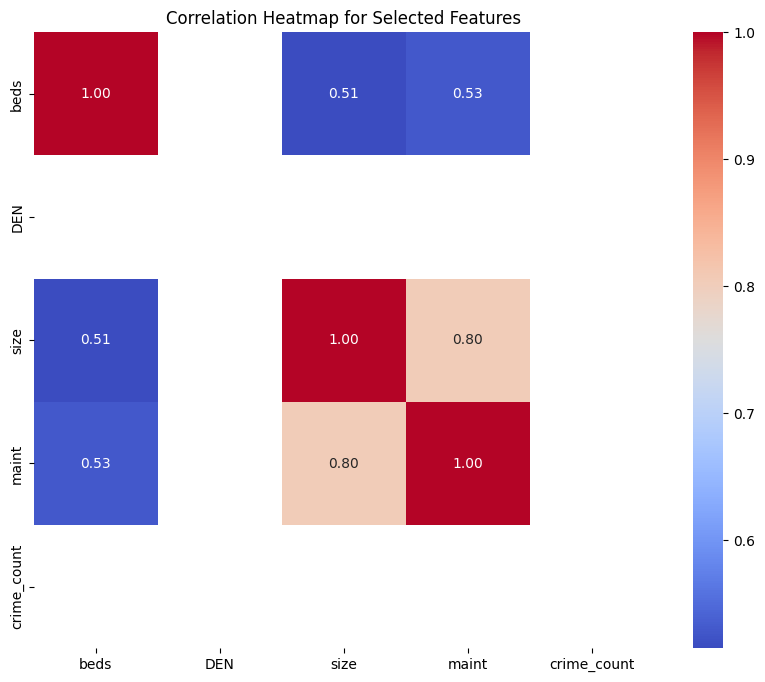

In [25]:
# Compute the correlation matrix for these features
corr_matrix_features = real_estate[features].corr()

plt.figure(figsize=(10, 8))

# Generate a heatmap with annotations for each correlation value
sns.heatmap(corr_matrix_features, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Selected Features")
plt.show()

In [26]:
# Create feature matrix X and target vector y
X = real_estate[features].values
y = real_estate[target].values

coords = real_estate[['lt', 'lg']].values

# Split into training and testing sets
X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X, y, coords, test_size=0.2, random_state=42)

# Normalize the features for neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train Tensorflow model

Feed forward neural network that drops neurons by 20% each layer to prevent overfitting, then adds back more

In [27]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

Early stopping

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # can also monitor 'val_mae'
    patience=5,            # stops if no improvement after 5 epochs
    restore_best_weights=True
)

Training the model and recording the training history for visuals

In [36]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40292454400.0000 - mae: 142591.0625 - val_loss: 30478151680.0000 - val_mae: 122649.6719
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48350199808.0000 - mae: 157092.7031 - val_loss: 30265008128.0000 - val_mae: 122318.5078
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45919313920.0000 - mae: 157020.8125 - val_loss: 30061764608.0000 - val_mae: 122016.7188
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43190022144.0000 - mae: 149428.5469 - val_loss: 29584490496.0000 - val_mae: 121302.7422
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36567527424.0000 - mae: 139508.1875 - val_loss: 29502238720.0000 - val_mae: 121258.7188
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 42182955008.0000 - mae: 146778.0156 - val_loss: 29311279104.0000 - val_mae: 121007.6016
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42524053504.0000 - mae: 147329.3438 - val_loss: 29132607488.0000 -

In [37]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22809835520.0000 - mae: 108349.2109
Test Loss: 25303638016.0, Test MAE: 114340.140625


The test loss says that an average squared error of around 22.82 billion, while the mean absolute error shows that on average, predictions are off by about 113,340 dollars. The typical error is around 113K dollars.

# Visualizations

Training and validation loss over epochs

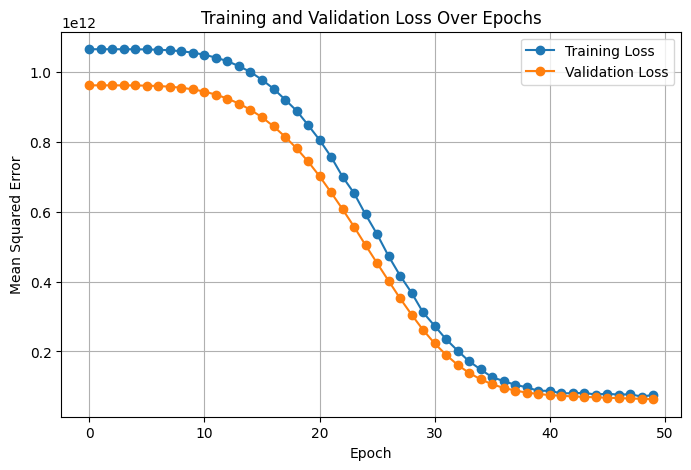

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Scatter plot of Actual vs Predicted Prices

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


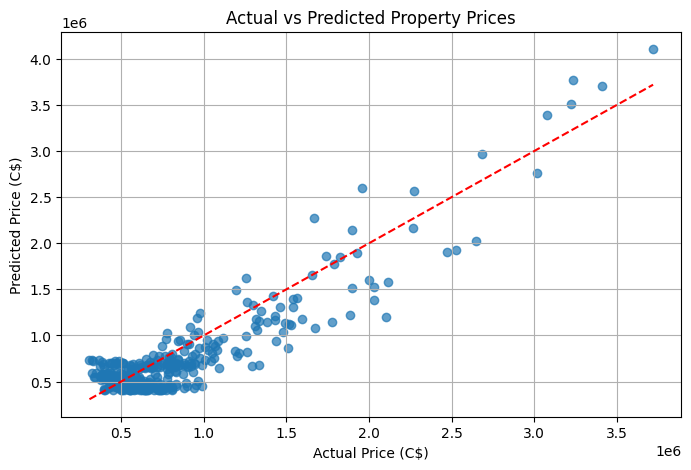

In [32]:
y_pred = model.predict(X_test_scaled).flatten()
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs Predicted Property Prices')
plt.xlabel('Actual Price (C$)')
plt.ylabel('Predicted Price (C$)')
plt.grid(True)
plt.show()

In [38]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Compute R² score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")

# Compute Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.4f}")

# Define percentage accuracy as (1 - MAPE) * 100
# Note: This is just one way to represent accuracy in regression and assumes prices are never zero.
accuracy_percentage = (1 - mape) * 100
print(f"Percentage Accuracy (based on MAPE): {accuracy_percentage:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² score: 0.9110
MAPE: 0.1439
Percentage Accuracy (based on MAPE): 85.61%


# Conclusion and model accuracy

Since the model achieved a mean absolute percent error of 0.1439, the model is precise at around 85.61% accurate in its predictions.